# 환경 최적화

In [ ]:
'''!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf'''

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,390 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
'''import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list'''

## Machine Learning Model 만들기

2월 부터 7월 까지 0시 부터 23시 까지  
아무 시간대나 입력하면 예측 값 출력해주는 모델 생성  
매일 자정에 모델 업데이트

처음부터 끝까지 사용해서 학습  
바로 직전 조건을 토대로 다음 결과 예측  
현재 + offset 시간  
바로 다음 또는 특정 시점의 환경 예측  
지금까지의 데이터를 토대로 수학 시점까지의 데이터 만들어 내서 만든 데이터 기반으로 수확량 예측  
지금까지의 기조가 유지되면 얼만큼의 수확량이 나오는지 계산  


** 특정 시점의 데이터 예측 후 부족한 점(습도, 온도)을 파악하여 팬, 급수펌프 가동

* Linear Regression
* Polynomial Regression
* Ridge Regression
* Lasso Regression
* PCR (Principal Component Regression)
* Elastic Net Regression
* Regression tree

### 머신러닝 패키지 호출

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import sklearn

PATH = '/content/drive/MyDrive/[2022]GraduationProject/'

warnings.filterwarnings(action='ignore')

# 한글 깨짐 방지

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from datetime import datetime

In [ ]:
file_name = 'weather.csv'
url = PATH + file_name

In [ ]:
origin_data = pd.read_csv(url)
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   수집일       6006 non-null   object 
 1   외부온도      5995 non-null   float64
 2   외부 일사량    5745 non-null   float64
 3   외부풍속      5647 non-null   float64
 4   강우감지      5995 non-null   float64
 5   내부온도      5995 non-null   float64
 6   내부습도      6002 non-null   float64
 7   내부CO2     3555 non-null   float64
 8   지온        5251 non-null   float64
 9   (양액)지습    6003 non-null   float64
 10  차광커튼작동상태  6006 non-null   int64  
 11  측창        6006 non-null   int64  
dtypes: float64(9), int64(2), object(1)
memory usage: 563.2+ KB


In [ ]:
timing_split = origin_data['수집일'].str.split(' ')
date = timing_split.str.get(0)
time = timing_split.str.get(1)

date_split = date.str.split('-')
hour_split = time.str.split(':')
hours = hour_split.str.get(0)
for i in range(len(hours)):
    if len(hours[i]) == 1:
        hours[i] = '0' + hours[i]

In [ ]:
origin_data.insert(1, 'year', date_split.str.get(0))
origin_data.insert(2, 'month', date_split.str.get(1))
origin_data.insert(3, 'day', date_split.str.get(2))
origin_data.insert(4, 'hour', hours)
origin_data.insert(2, 'month_day', origin_data['month'] + " " + origin_data['day'])

origin_data['수집일'] = pd.to_datetime(origin_data['수집일'])

flag = origin_data['수집일'][0]
tempDays = (origin_data['수집일'] - flag) * 24
Days = tempDays.astype(str)
days = Days.str.split(' ').str.get(0)

origin_data.insert(6, 'time', days)

origin_data['time'] = origin_data['time'].astype(int)

In [ ]:
origin_data

,수집일,year,month_day,month,day,hour,time,외부온도,외부 일사량,외부풍속,강우감지,내부온도,내부습도,내부CO2,지온,(양액)지습,차광커튼작동상태,측창
0,2020-09-10 00:00:00,2020,09 10,09,10,00,0,20.0,2.0,NaN,0.0,21.0,99.0,NaN,25.0,44.0,0,0
1,2020-09-10 01:00:00,2020,09 10,09,10,01,1,20.0,2.0,0.0,0.0,21.0,99.0,NaN,24.0,41.0,0,0
2,2020-09-10 02:00:00,2020,09 10,09,10,02,2,20.0,2.0,NaN,0.0,20.0,99.0,NaN,24.0,43.0,0,0
3,2020-09-10 03:00:00,2020,09 10,09,10,03,3,20.0,NaN,NaN,0.0,21.0,99.0,NaN,23.0,47.0,0,0
4,2020-09-10 04:00:00,2020,09 10,09,10,04,4,20.0,NaN,NaN,0.0,21.0,99.0,NaN,23.0,48.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,2021-06-28 11:00:00,2021,06 28,06,28,11,6995,28.0,827.0,0.0,1833.0,24.0,82.0,0.0,34.0,23.0,70,0
6002,2021-06-28 12:00:00,2021,06 28,06,28,12,6996,27.0,566.0,1.0,3667.0,23.0,84.0,0.0,36.0,23.0,70,0
6003,2021-06-28 13:00:00,2021,06 28,06,28,13,6997,29.0,765.0,1.0,0.0,25.0,81.0,0.0,37.0,22.0,70,0
6004,2021-06-28 14:00:00,2021,06 28,06,28,14,6998,26.0,452.0,1.0,5167.0,21.0,85.0,0.0,38.0,23.0,70,0


In [ ]:
threshold = origin_data[['내부온도', '내부습도', '(양액)지습']].mean()
threshold

내부온도      13.829691
내부습도      91.028657
(양액)지습    50.583208
dtype: float64

In [ ]:
# origin_data = origin_data.drop(axis=0)

In [ ]:
df_date = origin_data.groupby('month_day').mean()
df_date['time'] = df_date['time'].astype(int)
df_date

,time,외부온도,외부 일사량,외부풍속,강우감지,내부온도,내부습도,내부CO2,지온,(양액)지습,차광커튼작동상태,측창
month_day,,,,,,,,,,,,
01 28,3371,-0.041667,56.791667,0.708333,4833.333333,8.083333,95.291667,0.0,13.458333,52.916667,13.083333,0.0
01 29,3395,-4.250000,141.125000,0.541667,4131.916667,9.083333,92.916667,0.0,13.500000,53.250000,21.041667,0.0
01 30,3419,-0.791667,93.083333,0.083333,76.416667,9.083333,93.666667,0.0,14.166667,53.000000,21.458333,0.0
01 31,3443,3.875000,106.875000,0.208333,930.541667,9.833333,92.875000,0.0,15.041667,53.208333,21.500000,0.0
02 01,3467,7.875000,61.041667,0.666667,2881.916667,9.500000,95.916667,0.0,15.541667,53.583333,21.666667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12 26,2579,1.083333,127.210526,0.705882,0.000000,14.541667,95.541667,NaN,14.500000,51.041667,9.458333,0.0
12 27,2603,3.333333,39.000000,0.071429,3152.791667,12.708333,98.000000,NaN,13.500000,51.083333,8.375000,0.0
12 28,2627,1.928571,140.000000,0.000000,0.000000,10.000000,95.050000,0.0,12.357143,50.238095,7.333333,0.0


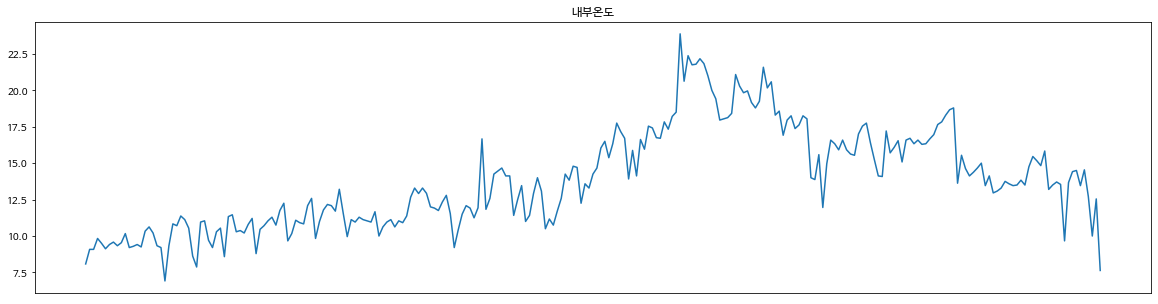

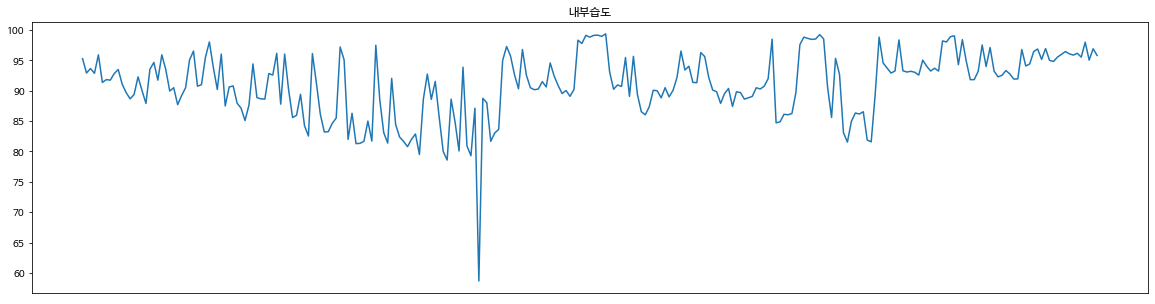

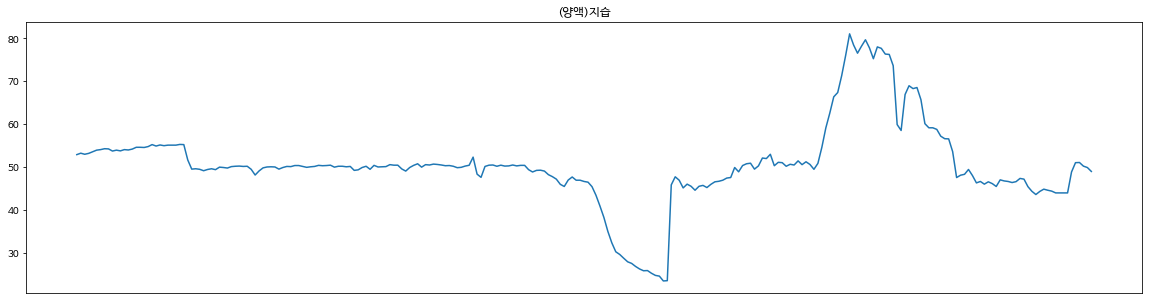

In [ ]:
x = df_date.index.values
cols = ['내부온도', '내부습도', '(양액)지습']

for col in cols:
    plt.figure(figsize=(20, 5))
    plt.title(col)
    plt.plot(x, df_date[col])
    plt.gca().axes.xaxis.set_visible(False)
    plt.show()

In [ ]:
df_data = df_date[cols]
df_data

,내부온도,내부습도,(양액)지습
month_day,,,
01 28,8.083333,95.291667,52.916667
01 29,9.083333,92.916667,53.250000
01 30,9.083333,93.666667,53.000000
01 31,9.833333,92.875000,53.208333
02 01,9.500000,95.916667,53.583333
...,...,...,...
12 26,14.541667,95.541667,51.041667
12 27,12.708333,98.000000,51.083333
12 28,10.000000,95.050000,50.238095


In [ ]:
df_data.to_csv("data4graph.csv", index = False)

하루 중 온도 변화 시간에 따라 저장

### Score 저장할 DF 생성

In [ ]:
models = ['Linear', 'Polynomial', 'Ridge', 'Lasso', 'ElasticNet']
modelLength = len(models)

In [ ]:
temp_score = pd.DataFrame({'model':['Linear', 'Polynomial', 'Ridge', 'Lasso', 'ElasticNet'],
                           'score':[0 for i in range(modelLength)],
                           'best_params':[0 for i in range(modelLength)],
                           'predict' : [0 for i in range(modelLength)],
                           'recommended':[0 for i in range(modelLength)]})

### Linear Regression

In [ ]:
model = LinearRegression()

In [ ]:
x = df_date['time']
temp = df_date['내부온도']
x_train, x_test, y_train, y_test = train_test_split(x, temp, test_size=0.25, random_state=0)

model1 = model
model1.fit(x_train[:, np.newaxis], y_train)
py = model1.predict(x_test[:, np.newaxis])
score = model1.score(x_test[:, np.newaxis], y_test)
predict = model1.predict(x[-1].reshape(-1, 1))[0]
temp_score['score'][temp_score['model'] == 'Linear'] = score
temp_score['predict'][temp_score['model'] == 'Linear'] = predict
score

0.31194916871692346

### Polynomial Regression

In [ ]:
degree = 2
n = 30

In [ ]:
x = df_date['time']
temp = df_date['내부온도']
x_train, x_test, y_train, y_test = train_test_split(x, temp, test_size=0.25, random_state=0)
score = pd.DataFrame(index=range(0,n), columns = {'degree', 'score'})

for i in range(n):
    degree = i+1
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), 
                      ('linear', LinearRegression(fit_intercept=False))])
    model.fit(x_train[:, np.newaxis], y_train)
    py = model.predict(x_test[:, np.newaxis])
    score['degree'][i] = degree
    score['score'][i] = model.score(x_test[:, np.newaxis], y_test)

score['degree'] = score['degree'].astype(int)
score['score'] = score['score'].astype(float)
best_degree = score.loc[score['score'].idxmax()]['degree'].astype(int)

degree = best_degree
model = Pipeline([('poly', PolynomialFeatures(degree=degree)), 
                  ('linear', LinearRegression(fit_intercept=False))])
model.fit(x_train[:, np.newaxis], y_train)
py = model.predict(x_test[:, np.newaxis])
best_score = model.score(x_test[:, np.newaxis], y_test)
predict = model.predict(x[-1].reshape(-1, 1))[0]
print('best_degree : ', best_degree, '\nbest_score : ', best_score, '\npredict : ', predict)
temp_score['score'][temp_score['model'] == 'Polynomial'] = best_score
temp_score['best_params'][temp_score['model'] == 'Polynomial'] = best_degree
temp_score['predict'][temp_score['model'] == 'Polynomial'] = predict

best_degree :  2 
best_score :  0.8213914658971256 
predict :  11.857250362760222


### Ridge Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [ ]:
model = Ridge()
parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

In [ ]:
rr = model
x = df_date['time'].values.reshape(-1, 1)
temp = df_date['내부온도'].values.reshape(-1, 1)
ridge = GridSearchCV(rr, parameters, scoring='neg_mean_squared_error', cv=5)
ridge.fit(x, temp)
predict = ridge.predict(x[-1].reshape(-1, 1))[0,0]
temp_score['score'][temp_score['model'] == 'Ridge'] = 1 + ridge.best_score_
temp_score['best_params'][temp_score['model'] == 'Ridge'] = ridge.best_params_
temp_score['predict'][temp_score['model'] == 'Ridge'] = predict

In [ ]:
predict = ridge.predict(x[-1].reshape(-1, 1))[0,0]
predict

14.516085777717306

In [ ]:
x[-1].reshape(-1,1)

array([[2693]])

### Lasso Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [ ]:
model = Lasso()
parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

In [ ]:
la = model
x = df_date['time'].values.reshape(-1, 1)
temp = df_date['내부온도'].values.reshape(-1, 1)
lasso = GridSearchCV(la, parameters, scoring='neg_mean_squared_error', cv=5)
lasso.fit(x, temp)
predict = lasso.predict(x[-1].reshape(-1, 1))[0]
temp_score['score'][temp_score['model'] == 'Lasso'] = 1 + lasso.best_score_
temp_score['best_params'][temp_score['model'] == 'Lasso'] = lasso.best_params_
temp_score['predict'][temp_score['model'] == 'Lasso'] = predict

### Elastic Net Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [ ]:
model = ElasticNet()
parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

In [ ]:
el = model
x = df_date['time'].values.reshape(-1, 1)
temp = df_date['내부온도'].values.reshape(-1, 1)
elasticNet = GridSearchCV(el, parameters, scoring='neg_mean_squared_error', cv=5)
elasticNet.fit(x, temp)
predict = elasticNet.predict(x[-1].reshape(-1, 1))[0]
temp_score['score'][temp_score['model'] == 'ElasticNet'] = 1 + elasticNet.best_score_
temp_score['best_params'][temp_score['model'] == 'ElasticNet'] = elasticNet.best_params_
temp_score['predict'][temp_score['model'] == 'ElasticNet'] = predict

* 환경데이터를 multivariable로 사용하여 기온 습도 등을 예측할 수 있는 방법 고안 -> 상관관계 값을 가중치로 활용하여 더하면 될 것 같음
* 날씨 예측 시점을 명확하게 하는 것이 필요해 보임

### Recommend Model

In [ ]:
temp_score[temp_score['model']== 'Linear']['score'].values[0]

0.31194916871692346

In [ ]:
models = ['Linear', 'Polynomial', 'Ridge', 'Lasso', 'ElasticNet']
modelLength = len(models)

In [ ]:
best_model = ''
max_score = 0

for model in models:
    score = temp_score['score'][temp_score['model'] == model].values[0]
    if score > max_score:
        max_score = score
        best_model = model

print('best_model : ', best_model, '\nmax_acc : ', max_score)
temp_score['recommended'][temp_score['model'] == best_model] = 1.0

best_model :  Polynomial 
max_acc :  0.8213914658971256


### Results

In [ ]:
temp_score

,model,score,best_params,predict,recommended
0,Linear,0.311949,0,14.381219,0
1,Polynomial,0.821391,2,11.857250,1
2,Ridge,-16.782356,{'alpha': 20},14.516086,0
3,Lasso,-16.773455,{'alpha': 20},14.512242,0
4,ElasticNet,-16.777822,{'alpha': 20},14.514162,0


In [ ]:
temp_score.to_csv("temp_score.csv", index = False)